## Higgs Effective Field Theory (HEFT) Study
## Approximate $\mathbb{P}(\lambda \le \lambda_0 | \theta) = \mathbb{E}(Z | \theta)$ by histogramming
> Created: Feb 12, 2024 Nicola de Filippis, Kurtis Johnson, Harrison B. Prosper<br>

### Introduction
The purpose of this project is to approximate $\mathbb{P}(\lambda \le \lambda_0 | \theta) = \mathbb{E}(Z | \theta)$ in two different ways: 1) using a 3D histogram and 2) a machine learning (ML) model, where for a given hypothesis $H_0: \theta = \theta_0$ versus $H_1: \theta \ne \theta_0$, $\lambda_0$ is the observed value of a test statistic $\lambda$ with the property that large values of the test statistic *disfavor* the hypothesis $H_0$. In this project, the physics model of interest is the Higgs effective field theory (HEFT), defined by a 5D parameter space of Wilson coefficients[1]:
\begin{align}
    \theta & = c_{hhh}, c_t, c_{tt}, c_{ggh}, c_{gghh}.
\end{align}

For this investigation, we restrict our attention to a single observable, namely, the di-Higgs mass denoted by $m_{hh}$. This notebook plots the differential cross section[1]
\begin{align}
    \frac{d\sigma}{d m_{hh}} 
    & = a_{1} c_{t}^{4} + a_{2} c_{tt}^{2} + a_{3} c_{t}^{2} c_{hhh}^{2} + a_{4} c_{ggh}^{2} c_{hhh}^{2}
    \nonumber\\
    & + a_{5} c_{gghh}^{2} + a_{6} c_{t}^{2} c_{tt} + a_{7} c_{t}^{3} c_{hhh} 
    \nonumber\\
    & + a_{8} c_{t} c_{hhh} c_{tt} + a_{9} c_{ggh} c_{hhh} c_{tt} + a_{10} c_{gghh} c_{tt} 
    \nonumber\\ 
    & + a_{11} c_{t}^{2} c_{ggh} c_{hhh} + a_{12} c_{t}^{2} c_{gghh} 
    \nonumber\\
    & + a_{13} c_{t} c_{ggh} c_{hhh}^{2} + a_{14} c_{t} c_{gghh} c_{hhh} \nonumber\\
    & + a_{15} c_{gghh} c_{ggh} c_{hhh} + a_{16} c_{t}^{3} c_{ggh} \nonumber\\
    & + a_{17} c_{t} c_{ggh} c_{tt} + a_{18} c_{t} c_{ggh}^{2} c_{hhh}  \nonumber\\
    & + a_{19} c_{t} c_{gghh} c_{ggh} + a_{20} c_{t}^{2} c_{ggh}^{2}  \nonumber\\ 
    & + a_{21} c_{ggh}^{2} c_{tt} + a_{22} c_{ggh}^{3} c_{hhh} \nonumber\\
    & + a_{23} c_{gghh} c_{ggh}^{2} , 
\end{align}
for each HEFT parameter point, where the coefficients $a_i$ depend on the di-Higgs mass $m_{hh}$. In this investigation, we set $c_{hhh} = c_t = 1$, which reduces the parameter space to 3 dimensions (note, `klambda` is a synonym for $c_{hhh}$) in which case the differential cross section simplifies to
\begin{align}
    \frac{d\sigma}{d m_{hh}} & = b_1 \nonumber\\
    & + b_2 c_{gghh} + b_3 c_{ggh} + b_4 c_{tt} \nonumber\\ 
    & + b_5 c_{tt} c_{gghh} +  b_6 c_{gghh} c_{ggh} + b_7 c_{tt} c_{ggh} 
    \nonumber\\
    &  + b_8 c_{tt} c_{ggh}^2 + b_9 c_{gghh} c_{ggh}^2 + b_{10} c_{tt}^2  + b_{11} c_{gghh}^2 + b_{12} c_{ggh}^2 + b_{13} c_{ggh}^3 ,
\end{align}
where we have introduced 13 new coefficients, $b_i(m_{hh})$, formed from the original coefficients $a_i$.

### Approximating $\mathbb{P}(\lambda \le \lambda_0 | \theta) = \mathbb{E}(Z | \theta)$ by histogramming

The quantity $\mathbb{E}(Z | \theta)$ can be approximated using the following algorithm, which therefore provides a way to check the quality of the deep neural network model.

  1. Create histogram $h_w \gets \text{histogram}(\theta, \text{weight}=Z)$
  1. Create histogram $h_u \gets \text{histogram}(\theta, \text{weight}=1)$
  1. Approximate $\mathbb{P}(\lambda \le \lambda_0 | \theta)$ by $h_w \, / \, h_u$

### References
  1. Lina Alasfar *et al.*, arXiv:2304.01968v1
  1. Ann Lee *et al.*, https://arxiv.org/abs/2107.03920

In [1]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline

# standard scientific python module
import scipy as sp
import scipy.stats as st
import scipy.optimize as op

# pytorch
import torch
import torch.nn as nn

# split data into a training set and a test set
from sklearn.model_selection import train_test_split

# to reload modules
import importlib

In [2]:
# update fonts
FONTSIZE = 16
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 217
rnd  = np.random.RandomState(seed)

### Load data

Note 1: $\kappa_\lambda \equiv c_{hhh}$.

Note 2: The bin widths in $m_{hh}$ is 15 GeV.

In [3]:
BIN_WIDTH = 15.0 # GeV

datafile = f'../data/powheg_total_param_closeBP.csv'

print('loading %s' % datafile)
dfBP = pd.read_csv(datafile)
print('number of rows:', len(dfBP))

dfBP[:5]

loading ../data/powheg_total_param_closeBP.csv
number of rows: 168


,klambda,CT,CTT,CGHH,CGGHH,0,1,2,3,4,...,92,93,94,95,96,97,98,99,100,101
0,1.0,1.0,-1.5,-0.6,0.6,0.0,0.0,0.0,0.0,0.0,...,0.005091,0.005331,0.003152,0.003647,0.003640,0.002667,0.002908,0.003146,0.004364,0.095064
1,1.0,1.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000858,0.001574,0.001289,0.001002,0.000430,0.001001,0.000429,0.001001,0.000430,0.012881
2,1.0,1.0,0.5,0.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000134,0.000134,0.000144,0.000072,0.000123,0.000061,0.000153,0.000093,0.000113,0.002095
3,1.0,1.0,-3.0,-1.0,-0.8,0.0,0.0,0.0,0.0,0.0,...,0.018563,0.006749,0.015196,0.010141,0.015190,0.010134,0.013507,0.003378,0.008441,0.130053
4,1.0,1.0,-3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.013665,0.015821,0.019422,0.014372,0.010073,0.015819,0.014374,0.010777,0.014385,0.281800


In [4]:
datafile = f'../data/powheg_total_param_SM.csv'

print('loading %s' % datafile)
dfSM = pd.read_csv(datafile)
print('number of rows:', len(dfSM))

dfSM

loading ../data/powheg_total_param_SM.csv
number of rows: 1


,klambda,CT,CTT,CGHH,CGGHH,0,1,2,3,4,...,92,93,94,95,96,97,98,99,100,101
0,1,1,0,0,0,0,0,0,0,0,...,0.000031,0,0.00001,0.000042,0,0.00001,0.000042,0.00001,0.000031,0.000157


### Convert to $\texttt{numpy}$ arrays

In [5]:
# get Wilson coefficients
wilson = dfBP[['CTT', 'CGHH', 'CGGHH']].to_numpy()
print(wilson.shape)

# get spectra
first_bin= 15
last_bin = 100

# construct bin names
cols = [str(x) for x in range(first_bin, last_bin)]
BP = dfBP[cols].to_numpy()
SM = dfSM[cols].to_numpy()

print(BP.shape)

(168, 3)
(168, 85)


### Get total cross sections (in pb) and protect against negative HEFT bins

In [6]:
SM.min(), SM.max(), BP.min(), BP.max()

(0.0, 0.017281655, -0.0002928526955656, 2.342081546783448)

In [7]:
BP = np.where(BP < 0, 0, BP) # protect against negative cross sections
SM_xsec = SM.sum()
BP_xsec = BP.sum(axis=1)
print(f'cross section (SM): \t\t{SM_xsec:8.3f} pb')
print(f'cross section (BP) (min, max):  {BP_xsec.min():8.3f} pb, {BP_xsec.max():8.3f} pb')

cross section (SM): 		   0.223 pb
cross section (BP) (min, max):     0.076 pb,   43.762 pb


### Plot $m_{hh}$ spectra

In [8]:
def plot_spectra(d, ymax=2.5, alpha=0.5, ylabel=r'$d\sigma$ (pb)',
                 filename='figures/fig_mhh.pdf', 
                 fgsize=(8, 4), ftsize=18):

    # compute mid-points of bins and map mhh to unit interval
    m, xbins = d.shape
    x = np.linspace(0, 1, xbins+1)
    
    # x[1:] = x[1], x[2] ...,x[n-1]
    # x[:-1]= x[0], x[1],...,x[n-2]
    x = (x[1:]+x[:-1])/2

    # make a plot with a single figure
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fgsize)

    xmin, xmax = 0, 1.0
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(r'$m_{hh}$', fontsize=ftsize)

    ymin = 0
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(ylabel, fontsize=ftsize)

    # loop over HEFT points
    for row in d:
        ax.hist(x, 
                bins=xbins, 
                range=(xmin, xmax), 
                weights=row,
                alpha=alpha)
    ax.grid() 
    
    plt.tight_layout()
    plt.savefig(filename)
    return

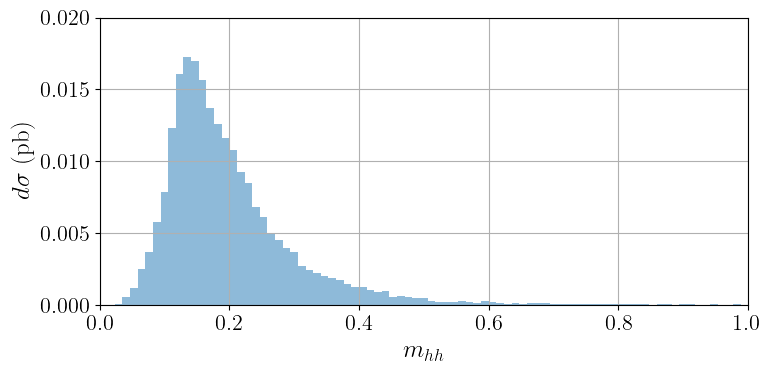

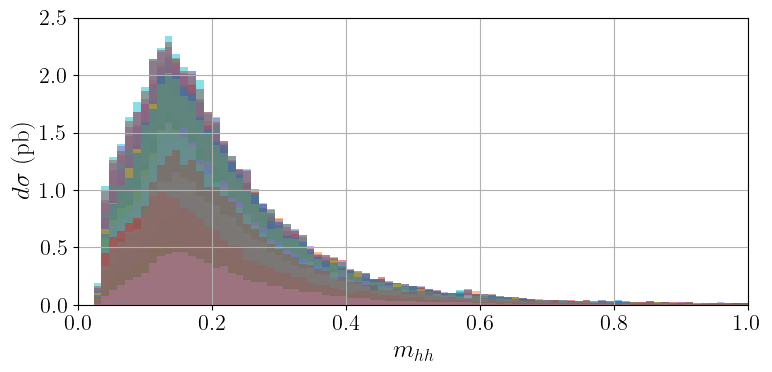

In [9]:
plot_spectra(SM, ymax=0.02, filename='figures/fig_mhh_SM.pdf')
plot_spectra(BP, ymax=2.50, filename='figures/fig_mhh_BP.pdf')

### Bin HEFT parameter points using $\texttt{turtlebinning}$

The parameter points to be binned, $\{(x_i, y_i, z_i), i=1,\cdots,N \}$ must be flattened into a single array arranged as follows:
$x_1,\cdots,x_N, y_1,\cdots,y_N, z_1,\cdots,z_N$. The $\texttt{numpy}$ array `wilson` is of shape (168, 3), so we must first transpose it to shape (3, 168) and then flatten it.

See the example below.

In [10]:
a = np.array([[1,2,3], [1,2,3], [1,2,3], [1,2,3]])
a.shape, a, a.T.flatten()

((4, 3),
 array([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]]),
 array([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]))

$\texttt{turtlebinning}$ is a convenient wrapper arpund the ROOT class TKDTreeBinnning.

In [11]:
import turtlebinning as tb
from array import array

Welcome to JupyROOT 6.30/02
	loading turtlebinning


In [12]:
# create a simple (i.e., a non-numpy) array
data = array('d')
# transpose and flatten the 2D wilson array
data.extend(wilson.T.flatten())

# bin data
npoints = len(wilson) # number of HEFT parameter points
nbins = 14            # number of bins
ndims = 3             # dimension of parameter space
ttb   = tb.Turtle(data, nbins, npoints, ndims)

building indices map...
           0
done
number of bins: 14
entries/bin:    12
data size:      168


### Construct "observed" spectrum

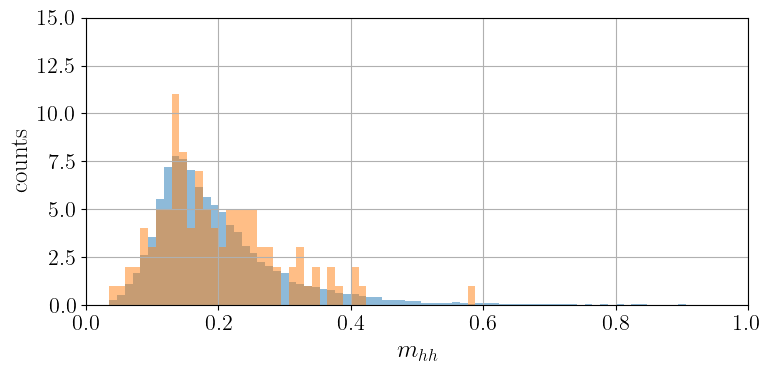

In [13]:
SM_mean_count = 100

# effective integrated luminosity
L_eff = SM_mean_count / SM_xsec

# compute Poisson means
SM_A = SM * L_eff

# generate "observed" data
D = np.random.poisson(SM_A)

# make a plot
T = np.concatenate([SM_A, D])
plot_spectra(T, ymax=15, ylabel='counts', filename='figures/fig_mhh_obs.pdf')

### Generate spectrum $X_j$ at each HEFT point $\theta_j$
For simplicity, for now, we'll assume the same effective integrated luminosity.

(168, 85) (168, 85)


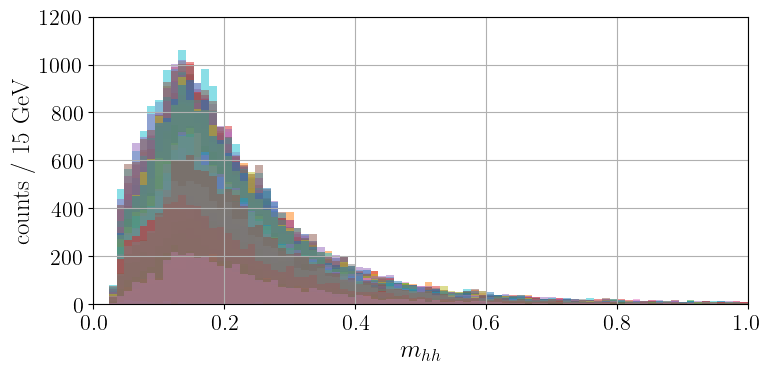

In [14]:
# compute mean counts at each HEFT point
BP_A = BP * L_eff 

# generate data at each HEFT point
X = np.random.poisson(BP_A)
print(X.shape, BP_A.shape)

# make a plot
plot_spectra(X, ymax=1200, ylabel='counts / 15 GeV', filename='figures/fig_mhh_X.pdf')

### Construct test statistic

For now, we'll use the following simple test statistic,
\begin{align}
    \lambda(X; \theta) & = \frac{1}{M} \sum_{i=1}^M \frac{(X_i - T_i(\theta))^2}{T_i(\theta)},
\end{align}
where $M$ is the number of bins with non-zero predicted mean counts. We hasten to add that the density of $\lambda$, $f(\lambda | \theta)$ is not necessarily $\chi^2$! The only requirement for $\lambda$ is that large values cast doubt on the hypothesis $H_0 : \theta = \theta_0$.

Given the effective integrated luminosity, $\ell = \epsilon {\cal L}$, the mean event count is $n = \sigma \, {\cal L}$, where $\epsilon$ and ${\cal L}$ are the efficiency (times acceptance) and integrated luminosity, respectively, We'll assume an effective integrated luminosity such that the mean `SM_mean_count` $= 100$ events. Then we sample from the SM $m_{hh}$ spectrum to mimic the *fixed* "observed" data, $D$, and we sample from the predicted spectrum at each of the HEFT parameter points taking care to use the correct mean count relative to that of the SM.

  1. Normalize the SM spectrum so that the area = mean count.
  3. Create "observed" $m_{hh}$ spectrum by sampling each bin independently using a Poisson distribution.
  4. Loop over each of the HEFT points and generate data from the predicted spectrum.

In [15]:
def test_statistic(X, T, T_min=0):
    t = np.where(T > 0, T, 1)
    l = ((X - t)**2 / t)
    return l.mean(axis=1)

### Compute indicators $Z_j = \mathbb{I}[\lambda(X_j; \theta_j) \leq \lambda(D; \theta_j)]$

For every HEFT parameter point $\theta_j = (c_{tt}, c_{ghh}, c_{gghh})_j$ compute $Z_j$.

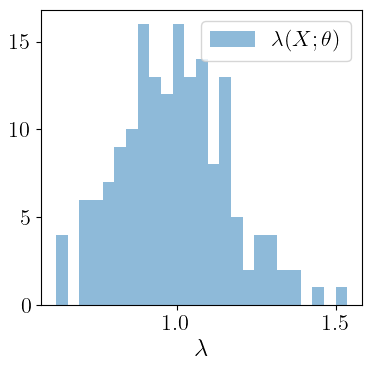

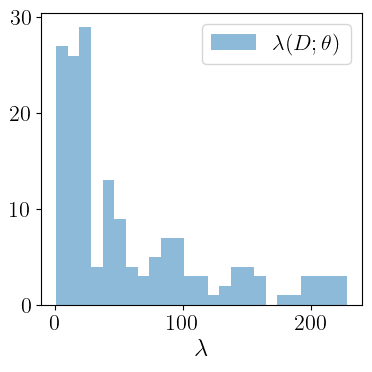

In [16]:
def plot_test_statistics(l, xbins=25, label='',
                 filename='figures/fig_test_stats.pdf', 
                 fgsize=(4, 4), ftsize=18):

    # make a plot with a single figure
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fgsize)

    ax.set_xlabel(r'$\lambda$', fontsize=ftsize)
    ax.hist(l, bins=xbins, alpha=0.5, label=label)
    #ax.set_xscale('log')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(filename)

# compute test statistics
lx = test_statistic(X, BP_A)
l0 = test_statistic(D, BP_A)

plot_test_statistics(lx, label=r'$\lambda(X;\theta)$')
plot_test_statistics(l0, label=r'$\lambda(D;\theta)$')